In [1]:
import numpy as np
import pandas as pd
from src.experiments import ExperimentMosquitoClassifier
from sklearn.metrics import classification_report
import src.classification as lc
from openmax.confusion_matrix_jhu import *
from sklearn.metrics import accuracy_score, f1_score
from openmax.openmax import OpenMaxYOLOCLIP
import torch
from openmax.openmax import create_model

USE_CHANNEL_LAST = False
DATASET = "laion"
DEVICE = "cuda:0"
PRESERVE_ASPECT_RATIO = False
SHIFT = 0


FOLD = "FINAL"

yolo_path = "./yolo/runs/detect/train_4class_noGbif/weights/best.pt"

clip_model_path = './checkpoints/CLIP_anno2_FINAL/epoch=13-val_loss=0.5767459869384766-val_f1_score=0.9142367839813232-val_multiclass_accuracy=0.9027796387672424.ckpt'

# for openmax and testing
CLASS_DICT = {
    "albopictus"        : torch.tensor(0, dtype=torch.float),
    "culex"             : torch.tensor(1, dtype=torch.float),
    "japonicus/koreicus": torch.tensor(2, dtype=torch.float),
    "culiseta"          : torch.tensor(3, dtype=torch.float),
}


class_dict = {
    "albopictus"        : torch.tensor(0, dtype=torch.float),
    "culex"             : torch.tensor(1, dtype=torch.float),
    "japonicus/koreicus": torch.tensor(2, dtype=torch.float),
    "culiseta"          : torch.tensor(3, dtype=torch.float),
    "mosquito"          : torch.tensor(4, dtype=torch.float)
}  

LABELS = [0, 1, 2, 3]

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
dataset = 'datacomp_xl_s13b_b90k'
aug = 'hca'
bs = 16
img_size = (224, 224)
shift_box = False

img_dir = "" 

val_annotations_csv = "../data_round_2/mosAlert_new_annotation_2/val_annotation_2.csv"
train_annotations_csv = "../data_round_2/mosAlert_new_annotation_2/train_annotation_2.csv"
test_annotations_csv = "../data_round_2/mosAlert_new_annotation_2/test_annotation_2.csv"

train_df = pd.read_csv(train_annotations_csv)

train_df["img_fName"] = img_dir + train_df["img_fName"]


val_df = pd.read_csv(val_annotations_csv)
test_df = pd.read_csv(test_annotations_csv)
test_df = test_df.sample(frac=1).reset_index(drop=True) 

train_dataloader, _, _ = ExperimentMosquitoClassifier(".", "",
                                                       class_dict=CLASS_DICT,
                                                       class_dict_test=class_dict).get_dataloaders(
    train_df,
    val_df,
    test_df,
    dataset,
    aug,
    bs,
    img_size,
    shift_box,
)

_, val_dataloader, test_dataloader = ExperimentMosquitoClassifier(img_dir, "",
                                                       class_dict=CLASS_DICT,
                                                       class_dict_test=class_dict).get_dataloaders(
    train_df,
    val_df,
    test_df,
    dataset,
    aug,
    bs,
    img_size,
    shift_box,
)

/home/pc2/miniconda3/envs/yolo/lib/python3.12/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/home/pc2/miniconda3/envs/yolo/lib/python3.12/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [6]:
for batch in test_dataloader:
    print(batch[0].shape)
    print(batch[1])
    break
    

torch.Size([16, 3, 224, 224])
tensor([1., 1., 0., 4., 1., 3., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.])


In [7]:
for batch in train_dataloader:
    print(batch[0].shape)
    print(batch[1])
    break

torch.Size([16, 3, 224, 224])
tensor([0., 3., 2., 3., 3., 2., 3., 1., 2., 2., 2., 2., 2., 0., 3., 3.])


In [10]:
model = lc.MosquitoClassifier.load_from_checkpoint(
            clip_model_path, head_version=7, map_location=torch.device(DEVICE)
        ).eval()

INFO:root:Loaded ViT-L-14 model config.
INFO:root:Loading pretrained ViT-L-14 weights (datacomp_xl_s13b_b90k).


In [11]:
for data in train_dataloader:
    print(data[0].shape)
    print(data[1].cpu().numpy().shape)
    break

torch.Size([16, 3, 224, 224])
(16,)


In [12]:
model.eval()

create_model(
    net=model,
    dataloader=train_dataloader,
    fold = FOLD,
    labels=LABELS,
    tailsize=20
)

Weibull model already fitted, fetching at weibull_models/weibull_model_anno2_FINAL.pkl


{0: {'mean': array([     1.6103,    -0.19487,    -0.13851,    -0.18375], dtype=float32),
  'weibull_model': <MR object: '1.059515682326926278023e+00 2.528970506670989948361e+01  1.110785154566392263220e+00 1.010612607201166301962e+00 5.308869516491136408831e+01 1.204718218020719611161e+01  1 5.000000000000000000000e+00 1 20 1 3.003671006485271188780e-01 0\n'>},
 1: {'mean': array([  -0.044571,      1.6942,    -0.12836,   -0.075569], dtype=float32),
  'weibull_model': <MR object: '1.072644122228541441189e+00 2.304203062019112735470e+01  1.129739396137135143405e+00 1.018434354759613080788e+00 5.084703447724300673372e+01 1.044181200654779573256e+01  1 5.000000000000000000000e+00 1 20 1 2.589782204604336723897e-01 0\n'>},
 2: {'mean': array([   -0.14513,    -0.28494,      1.5234,    -0.30436], dtype=float32),
  'weibull_model': <MR object: '1.133124652203623794477e+00 1.224330556508417799932e+01  1.249246421315067356872e+00 1.027796802555544841695e+00 2.633581997992844137002e+01 5.69181180

### test closed set only, and then open

Wanna test on 4 classes only.

In [13]:
test_df["class_label"].value_counts()

class_label
culex                 634
albopictus            516
mosquito              356
culiseta               96
japonicus/koreicus     54
Name: count, dtype: int64

In [14]:
closed_test = test_df[test_df["class_label"] != "mosquito"]
closed_test["class_label"].value_counts()

class_label
culex                 634
albopictus            516
culiseta               96
japonicus/koreicus     54
Name: count, dtype: int64

In [15]:
_, _, closed_test_dl = ExperimentMosquitoClassifier(img_dir, "",
                                                    class_dict=CLASS_DICT,
                                                    class_dict_test=class_dict).get_dataloaders(
    train_df,
    val_df,
    closed_test,
    dataset,
    aug,
    bs,
    img_size,
    shift_box,
)

/home/pc2/miniconda3/envs/yolo/lib/python3.12/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [16]:
device = torch.device('cuda:0')

def extract_labels(dataloader):
    labels_list = []
    
    for _, labels in dataloader:
        labels_list.append(labels.numpy())
    
    all_labels = np.concatenate(labels_list)
    return all_labels

def test(model, dl):
    '''Test acc model on dataloader'''

    model.eval()
    
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():  # Disable gradient calculation
        for data in dl:
            x, y = data
            x, y = x.to(device), y.to(device)
            
            y_h = model(x)
            # print(y_h)
            _, y_p = torch.max(y_h.data, 1)
            
            total += y.size(0)
            # print(y_p.shape)
            # print(y.shape)
            correct += (y_p == y).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(y_p.cpu().numpy())

    print(classification_report(y_true, y_pred))
            
    return correct / total


def macro_f1(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate the macro F1 score
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return macro_f1

In [17]:

open_model = OpenMaxYOLOCLIP(
    yolo_path=yolo_path,
    clip_path=clip_model_path,
    train_dl=train_dataloader,
    fold=FOLD,
    alpha_rank=4,
    tailsize=20,
    n_class=4,
)

# open_model = OpenMaxYOLOXception(
#     yolo_path=yolo_path,
#     xception_path=xception_path,
#     train_dl=train_dataloader,
#     fold=FOLD,
#     alpha_rank=4,
#     tailsize=20,
#     n_class=4,
# )


INFO:root:Loaded ViT-L-14 model config.
INFO:root:Loading pretrained ViT-L-14 weights (datacomp_xl_s13b_b90k).


Fitting weibull models...
Weibull model already fitted, fetching at weibull_models/weibull_model_anno2_FINAL.pkl


In [18]:
_, threshold = open_model.compute(train_dataloader)

In [19]:
threshold

0.12381241105341624

In [20]:
#stop

### No Openmax Model, Closed set

In [21]:
test(model, closed_test_dl) #closed

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       516
         1.0       0.98      0.98      0.98       634
         2.0       0.98      0.78      0.87        54
         3.0       0.85      0.88      0.86        96

    accuracy                           0.97      1300
   macro avg       0.94      0.91      0.92      1300
weighted avg       0.97      0.97      0.97      1300



0.9669230769230769

In [22]:
macro_f1(model, closed_test_dl, device='cuda:0')

0.9220746694990899

In [23]:
# np.unique(y_t)

### Openmax Model, Closed set

In [24]:

y_p = open_model.predict(closed_test_dl)
y_t = extract_labels(closed_test_dl)

print(classification_report(y_t, y_p))

thres:  0.10818563050329334
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       516
         1.0       0.99      0.86      0.92       634
         2.0       1.00      0.28      0.43        54
         3.0       0.99      0.69      0.81        96
         4.0       0.00      0.00      0.00         0

    accuracy                           0.86      1300
   macro avg       0.79      0.55      0.63      1300
weighted avg       0.99      0.86      0.91      1300



/home/pc2/miniconda3/envs/yolo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pc2/miniconda3/envs/yolo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pc2/miniconda3/envs/yolo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
f1_score(y_true=y_t, y_pred=y_p, average='macro')

0.6257301368371839

In [26]:
# f1_score(y_true=y_t, y_pred=y_p, average='micro')

### No Openmax Model, Open-set (doesnt mean anything as it cannot classify unknown anyway)

In [27]:
y_p = open_model.predict(test_dataloader)
y_t = extract_labels(test_dataloader)

thres:  0.10843193192615654


### Openmax Model, Open set

In [28]:
print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87       516
         1.0       0.95      0.87      0.90       634
         2.0       1.00      0.30      0.46        54
         3.0       0.72      0.70      0.71        96
         4.0       0.54      0.54      0.54       356

    accuracy                           0.79      1656
   macro avg       0.80      0.67      0.70      1656
weighted avg       0.80      0.79      0.79      1656



Normalized confusion matrix
Avg Acc 0.6697442221399148


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

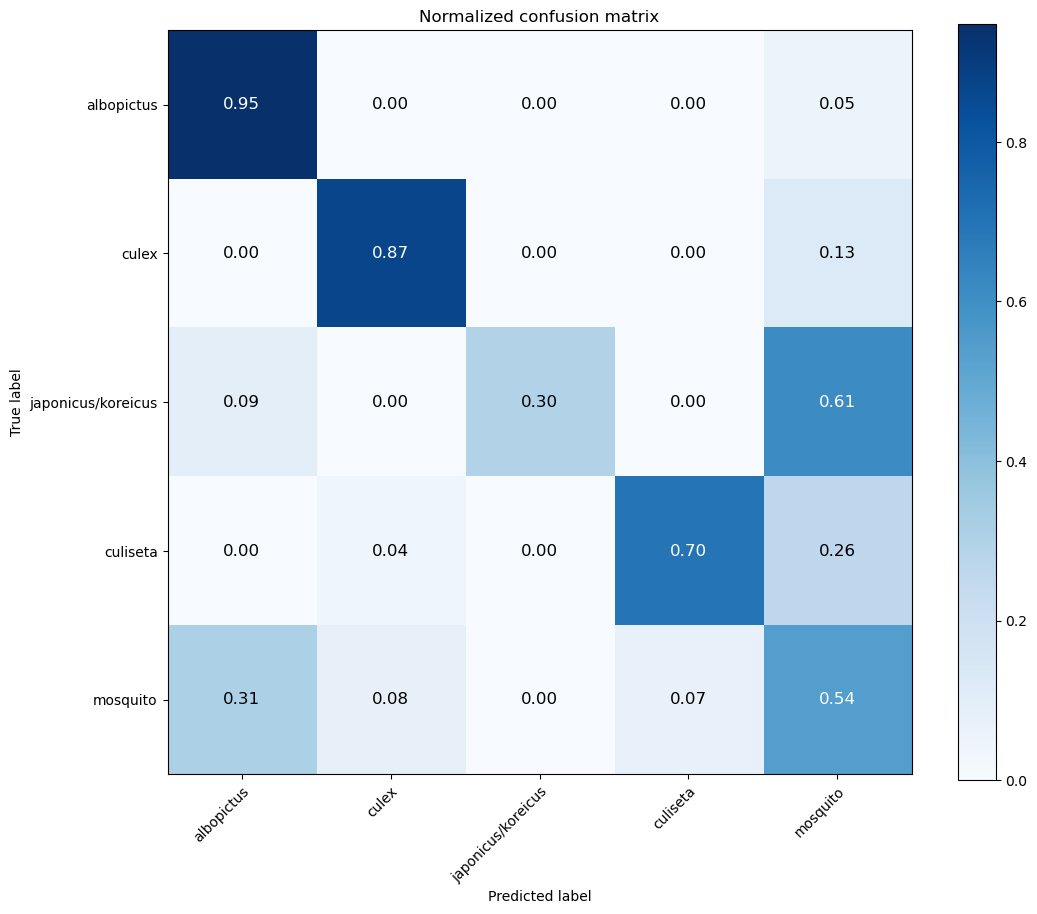

In [32]:



species_list = ["albopictus","culex","japonicus/koreicus", "culiseta", "mosquito"]
plot_pretty_blue_confusion_matrix(classes=species_list,
                                  y_true = y_t.tolist(), y_pred=y_p.tolist(),
                                  normalize=True,  
                                  savepath='confusion_matrix_jhu',
                                  figsize=(12,12))